# Capstone Project - Data Engineering Nanodegree Program

## Project Summary
The purpose of the data engineering capstone project is to combine and process big datasets using concepts and technologies learned throughout the nano degree program. We will use the Udacity provided project, containing four datasets: data on immigration to the United States, data on airport codes, U.S. city demographics, and temperature data.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [15]:
!pip install matplotlib

import pandas as pd
import findspark
from pyspark.sql import SparkSession
from zipfile import ZipFile, Path
import re

     |████████████████████████████████| 7.2 MB 3.1 MB/s 
     |████████████████████████████████| 61 kB 918 kB/s 
     |████████████████████████████████| 3.0 MB 36.2 MB/s 
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


## Project Steps

### Step 1: Scope the Project and Gather Data

#### Scope 

Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

**Plan**
 - Model + Tools
 - Source Data to S3
 - Create Pipeline
 - Stage Data from S3 in DWH
 - Combine Data and write it to DWH

**Tools**
 - AWS Redshift
 - Apaache Airflow
 - Spark
 - AWS S3
 

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

Since it is the Udacity provided project, you'll work with four datasets to complete the project. The main dataset will include data on immigration to the United States, and supplementary datasets will include data on airport codes, U.S. city demographics, and temperature data.

 - **I94 Immigration Data**:\
  This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.
 
 - **World Temperature Data**:\
  This dataset came from Kaggle: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
 
 - **U.S. City Demographic Data**:\
  This data comes from OpenSoft: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/
 
 - **Airport Code Table**:\
  This is a simple table of airport codes and corresponding cities: https://datahub.io/core/airport-codes#data


###### Immigration Data

In [7]:
# Read in the data here

i94imm_df = pd.read_csv('source_data/immigration_data_sample.csv')
i94imm_df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [8]:
# read sas data and write it to parquet

findspark.init()

host="127.0.0.1"

spark = SparkSession.builder\
    .master("local[*]")\
    .config("spark.jars.packages","saurfang:spark-sas7bdat:3.0.0-s_2.12")\
    .config("spark.driver.bindAddress",host)\
    .config("spark.driver.host",host)\
    .enableHiveSupport().getOrCreate()

df_spark =spark.read.format('com.github.saurfang.sas.spark').load('data/input/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

df_spark.write.mode("ignore").partitionBy("i94yr","i94mon").parquet("data/parquet")

###### World Temperature Data

In [9]:
with ZipFile('source_data/archive.zip') as myzip:
    data = myzip.open('GlobalLandTemperaturesByCity.csv')

temp_df = pd.read_csv(data)
temp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


###### U.S. Demographics Data

In [10]:
dem_df = pd.read_csv('source_data/us-cities-demographics.csv', sep=';')

dem_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402
1,Peoria,Illinois,33.1,56229.0,62432.0,118661,6634.0,7517.0,2.40,IL,American Indian and Alaska Native,1343
2,O'Fallon,Missouri,36.0,41762.0,43270.0,85032,5783.0,3269.0,2.77,MO,Hispanic or Latino,2583
3,Hampton,Virginia,35.5,66214.0,70240.0,136454,19638.0,6204.0,2.48,VA,Black or African-American,70303
4,Lakewood,Colorado,37.7,76013.0,76576.0,152589,9988.0,14169.0,2.29,CO,Hispanic or Latino,33630


##### Airport Codes

In [11]:
with ZipFile('source_data/airport-codes_zip.zip') as myzip:
    data = myzip.open('data/airport-codes_csv.csv')

airport_df = pd.read_csv(data)
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


### Step 2: Explore and Assess the Data
#### Explore the Data: Immigration data 
Identify data quality issues, like missing values, duplicate data, etc.


In [12]:
i94imm_agg_df = i94imm_df.iloc[: , 1:].agg(['nunique','count','size'])
i94imm_agg_df

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
nunique,1000,1,1,88,91,70,30,4,51,109,...,0,1,85,99,3,29,101,1000,502,10
count,1000,1000,1000,1000,1000,1000,1000,1000,941,951,...,0,954,1000,1000,859,35,967,1000,992,1000
size,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


In [13]:
# print uniq values for columnst with maximum 100 differen values
for row in i94imm_agg_df.T.itertuples():
    nunique = row[1]
    count = row[2]
    size = row[3]
    print('\n',row.Index, nunique, count, size)
    if(nunique < 100):
        print(i94imm_df[row.Index].unique())


 cicid 1000 1000 1000

 i94yr 1 1000 1000
[2016.]

 i94mon 1 1000 1000
[4.]

 i94cit 88 1000 1000
[209. 582. 148. 297. 111. 577. 245. 113. 131. 116. 438. 260. 512. 689.
 746. 115. 251. 268. 129. 213. 135. 133. 373. 126. 252. 696. 117. 687.
 528. 123. 258. 691. 130. 107. 103. 694. 254. 574. 368. 575. 586. 734.
 514. 273. 692. 109. 579. 164. 263. 464. 124. 602. 121. 162. 274. 690.
 207. 104. 525. 105. 343. 576. 585. 272. 108. 114. 140. 180. 526. 603.
 332. 513. 516. 218. 204. 296. 201. 257. 266. 520. 718. 112. 261. 299.
 688. 141. 350. 340.]

 i94res 91 1000 1000
[209. 582. 112. 297. 111. 577. 245. 135. 131. 116. 438. 260. 512. 689.
 158. 115. 511. 251. 268. 585. 213. 264. 509. 324. 696. 117. 687. 129.
 528. 123. 258. 691. 130. 107. 103. 694. 276. 206. 368. 575. 586. 120.
 514. 124. 273. 692. 109. 579. 164. 126. 263. 464. 602. 121. 162. 274.
 690. 207. 104. 525. 105. 518. 343. 504. 576. 272. 108. 127. 140. 526.
 603. 332. 513. 516. 218. 296. 204. 201. 114. 257. 266. 520. 243. 261.
 113.

['F' 'M' nan 'X']


<AxesSubplot:xlabel='gender'>

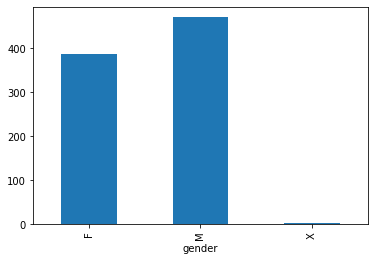

In [16]:
print(i94imm_df['gender'].unique())

i94imm_df['gender'].groupby(i94imm_df['gender']).count().plot(kind="bar")

#### Cleaning Steps: Immigration data
Document steps necessary to clean the data

#### Explore the Data: World Temperature Data

#### Cleaning Steps: World Temperature Data

#### Explore the Data: U.S. Demographics Data

#### Cleaning Steps: U.S. Demographics Data

#### Explore the Data: Airport Codes

#### Cleaning Steps:  Airport Codes

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.